In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from catboost import CatBoostRegressor
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVR

In [2]:
# Функция для преобразования формата скорости ветра

def extract_value(value):
    if isinstance(value, (int, float)):
        return value
    match = re.search(r'\((\d+\.\d+)\)', str(value))
    if match:
        return float(match.group(1))
    return value

In [23]:
# Функция загрузки и подготовки данных по нужным веществам из всех 6 геоточек

def load_data(num, all_substances, meteo_params):
    '''num - номер геоточки
       all_substances - названия загрязняющих веществ
    '''
    
    point = pd.read_excel(f'../data/raw/Усредненные_данные_Нижнекамск_т.{num}.xlsx')
    indexes = list(point.loc[0])
    indexes = indexes[1:]
    point = point.loc[3:].set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))
    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)
        
    # Пересечение множеств названий столбцов и substances
    substances = set(indexes) & set(all_substances)
    columns = [*substances, *meteo_params]
    point = point[columns]

    # Заполнение пропусков, если их в столбце не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
        if point[col].isna().sum().sum() / len(point) < 0.05:
            point[col].interpolate(inplace=True)
        
    return point

In [24]:
def melt_columns(df, substances, Mr, meteo_params):
    """Функция 'расплавления' столбцов с веществами"""
    
    df = pd.melt(df, id_vars=meteo_params, ignore_index=False)

    # Закодируем названия веществ их молекулярной массой
    df.replace(substances, Mr, inplace=True)
    df.rename(columns={"variable": "Mr", "value": "C, мг/м³"}, inplace=True)

    df["Mr"] = pd.to_numeric(df["Mr"], errors='coerce')

    return df

In [25]:
def make_df(df, num, target_num, lags=None):
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    '''

    coor = locations_list[num - 1]
    target_coor = locations_list[target_num - 1]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

In [26]:
def split_scale_df(X, y):
    
    # Разбиваем
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Масштабируем X
    scl = StandardScaler()
    scl.fit(X_train)
    X_train_scl = scl.transform(X_train)
    X_test_scl = scl.transform(X_test)

    return X_train_scl, X_test_scl, y_train, y_test

In [27]:
locations_list = [
    [55.539306, 051.856451],    # д. Клятле
    [55.622944, 051.825578],    # ул. Ахтубинская, 4б
    [55.650091, 051.852687],    # ул. Гагарина, 32
    [55.598983, 051.771936],    # ул. Юбилейная, 3
    [55.613193, 051.784821],    # ул. Южная, 3
    [55.654578, 051.800072]     # ул. Ямьле, 20
    ]

substances = ['CO, мг/м³',
              'NO, мг/м³',
              'NO2, мг/м³', 
              'NH3, мг/м³',
              'SO2, мг/м³',
              'H2S, мг/м³'
              ]
# Молекулярные массы веществ из substances
Mr = [28, 30, 46, 17, 64, 34]

meteo_params = ['V ветра, м/с',
                'Угол ветра, °',
                'Направление ветра'
               ]

Ранее модели определяли концентрации в геоточке №6, до нее из каждой точки рассчитывались растояния.  
Теперь же проделаем это все для каждой из точек: концентрации в каждой из шести точек по очереди будут целевыми концентрациями для остальных пяти точек, далее все датафреймы объединим в один.

In [28]:
point1 = load_data(1, substances, meteo_params)
point2 = load_data(2, substances, meteo_params)
point3 = load_data(3, substances, meteo_params)
point4 = load_data(4, substances, meteo_params)
point5 = load_data(5, substances, meteo_params)
point6 = load_data(6, substances, meteo_params)

points = [point1, point2, point3, point4, point5, point6]

In [29]:
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

Расшифровка:  
```
point1_melted = melt_columns(point1, substances, Mr)
point2_melted = melt_columns(point2, substances, Mr)
point3_melted = melt_columns(point3, substances, Mr)
point4_melted = melt_columns(point4, substances, Mr)
point5_melted = melt_columns(point5, substances, Mr)
point6_melted = melt_columns(point6, substances, Mr)

```
X1_5 = make_df(point1_melted, 1, 5)
X2_5 = make_df(point2_melted, 2, 5)
X3_5 = make_df(point3_melted, 3, 5)
X4_5 = make_df(point4_melted, 4, 5)
# X5_5
X6_5 = make_df(point6_melted, 6, 5)
X__5 = pd.concat([X1_5, X2_5, X3_5, X4_5, X6_5], axis=0)

In [30]:
def concat_dfs(df_melted_list, num, lags=5):

    X_list = [make_df(df, i+1, num, lags) for i, df in enumerate(df_melted_list)]
    del X_list[num - 1]    # удаляем сопоставление точки самой с собой
    X_num = pd.concat(X_list, axis=0)
    return X_num

X_1 = concat_dfs(df_melted_list, 1)
X_2 = concat_dfs(df_melted_list, 2)
X_3 = concat_dfs(df_melted_list, 3)
X_4 = concat_dfs(df_melted_list, 4)
X_5 = concat_dfs(df_melted_list, 5)
X_6 = concat_dfs(df_melted_list, 6)
X_num_list = [X_1, X_2, X_3, X_4, X_5, X_6]

# X_num_list = [concat_dfs(df_melted_list, j+1) for j in range(len(df_melted_list))]

In [11]:
# Меняем вещество-таргет для нового обучения
for substance in substances:
    
    X_list_substance = copy.deepcopy(X_num_list)
    data_with_substance = []
    
    # Добавление целевой переменной
    for (num, X_num), point in zip(enumerate(X_list_substance), points):
        if substance in list(point):
            data_with_substance.append(X_num)
            data_with_substance[-1][f'target_{substance}'] = point[substance]
            
    # X_6[f'target_{substance}'] = point6[substance]
    # X_5[f'target_{substance}'] = point5[substance]
    # X_4[f'target_{substance}'] = point4[substance]
    # X_3[f'target_{substance}'] = point3[substance]
    # X_2[f'target_{substance}'] = point2[substance]
    # X_1[f'target_{substance}'] = point1[substance]

    # X = pd.concat([X_1, X_2, X_3, X_4, X_5, X_6], axis=0)
    X = pd.concat(data_with_substance, axis=0)
    X.dropna(inplace=True)
    X.drop_duplicates(inplace=True)
    X = pd.get_dummies(X, columns=['Направление ветра'])
    
    y = X.pop(f'target_{substance}')

    # Разбиваем и масштабируем
    X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
    # Обучение
    cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
    cb.fit(X_train_scl, y_train)
    
    pred = cb.predict(X_test_scl)
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0
    
    print('MAE =', mean_absolute_error(pred, y_test))
    print(substance)
    print()

735 отрицательных значений заменены на 0
MAE = 0.10900479426150686
CO, мг/м³

3601 отрицательных значений заменены на 0
MAE = 0.003066673726210319
NO, мг/м³

1347 отрицательных значений заменены на 0
MAE = 0.006855941150852361
NO2, мг/м³

4047 отрицательных значений заменены на 0
MAE = 0.0009144377649041786
NH3, мг/м³

1220 отрицательных значений заменены на 0
MAE = 0.009619995889484319
SO2, мг/м³

158 отрицательных значений заменены на 0
MAE = 0.0007434660188919097
H2S, мг/м³



In [ ]:
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

## Feature selection  
Добавим другие признаки: больше временных лагов и другие метеоданные

In [31]:
def create_df():
    '''Функция для создания датафрейма для сохранения метрик    
    '''
    df = pd.DataFrame(columns=['Кол-во лагов',
                               *substances,
                               'Σ(MAE)'
                              ]
                      ).set_index(['Кол-во лагов'])
    return df

mae_df = create_df()

In [32]:
def make_X_y():
    X_list_substance = copy.deepcopy(X_num_list)
    data_with_substance = []
    
    # Добавление целевой переменной
    for (num, X_num), point in zip(enumerate(X_list_substance), points):
        if substance in list(point):
            data_with_substance.append(X_num)
            data_with_substance[-1][f'target_{substance}'] = point[substance]
            
    X = pd.concat(data_with_substance, axis=0)
    X.dropna(inplace=True)
    X.drop_duplicates(inplace=True)
    X = pd.get_dummies(X, columns=['Направление ветра'])
    y = X.pop(f'target_{substance}')
    return X, y

Варьируем лаги

In [33]:
for lags in range(9):
    X_num_list = [concat_dfs(df_melted_list, j+1, lags) for j in range(len(df_melted_list))]
    
    for substance in substances:
        X, y = make_X_y()
        X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
        # Обучение
        cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
        cb.fit(X_train_scl, y_train)
        
        pred = cb.predict(X_test_scl)
        pred[pred < 0] = 0
        
        mae = mean_absolute_error(pred, y_test)
        mae_df.at[lags, substance] = mae
        
    # Сумма ошибок по всем веществам
    sum_mae = mae_df.loc[lags].sum()
    mae_df.at[lags, 'Σ(MAE)'] = sum_mae

In [34]:
mae_df

,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³",Σ(MAE)
Кол-во лагов,,,,,,,
0,0.118648,0.003512,0.007464,0.00102,0.010298,0.000799,0.141741
1,0.118648,0.003512,0.007464,0.00102,0.010298,0.000799,0.141741
2,0.115811,0.003345,0.007103,0.000982,0.010006,0.000779,0.138026
3,0.113713,0.003225,0.007022,0.00095,0.009858,0.000767,0.135535
4,0.111821,0.003154,0.006878,0.000941,0.00975,0.000755,0.1333
5,0.109005,0.003067,0.006856,0.000914,0.00962,0.000743,0.130205
6,0.108512,0.003001,0.006727,0.0009,0.009595,0.000737,0.129471
7,0.106028,0.003003,0.006727,0.000897,0.009634,0.00073,0.127018
8,0.104135,0.002954,0.006736,0.000887,0.009412,0.000725,0.124849


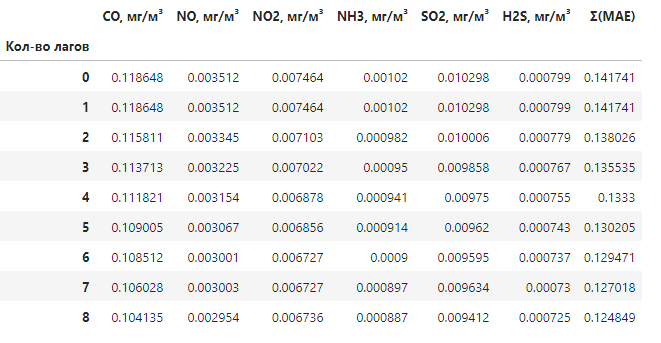  

Добавим столбец с температурой (T внеш.), столбец с давлением (P атм.)

In [16]:
def make_df(df, num, target_num, lags=None):
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    '''

    coor = locations_list[num - 1]
    target_coor = locations_list[target_num - 1]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"T внеш_{i}"] = df['T внеш., °C'].shift(i)    # для нового столбца
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

In [17]:
['T внеш., °C',
 'V ветра, м/с',
 'H внеш., %',
 'P атм., мм.рт.ст.',
 'R осадк., мм/ч',
 'Угол ветра, °',
 'Направление ветра']

meteo_params = ['T внеш., °C', 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']

In [21]:
points = [load_data(i, substances, meteo_params) for i in range(1, 7)]
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

for lags in range(9):
    X_num_list = [concat_dfs(df_melted_list, j+1, lags) for j in range(len(df_melted_list))]
    
    for substance in substances:
        X, y = make_X_y()
        X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
        # Обучение
        cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
        cb.fit(X_train_scl, y_train)
        
        pred = cb.predict(X_test_scl)
        pred[pred < 0] = 0
        
        mae = mean_absolute_error(pred, y_test)
        mae_df.at[lags, substance] = mae
        
    # Сумма ошибок по всем веществам
    sum_mae = mae_df.loc[lags].sum()
    mae_df.at[lags, 'Σ(MAE)'] = sum_mae

In [22]:
# C добавлением температуры
mae_df

,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³",Σ(MAE)
Кол-во лагов,,,,,,,
0,0.110354,0.002741,0.006717,0.000818,0.009542,0.000712,0.130885
1,0.110354,0.002741,0.006717,0.000818,0.009542,0.000712,0.130885
2,0.107957,0.002622,0.006495,0.000785,0.008915,0.000687,0.127461
3,0.105887,0.002574,0.006325,0.00077,0.008954,0.000675,0.125185
4,0.103947,0.002518,0.006231,0.000752,0.008756,0.000664,0.122868
5,0.101485,0.002515,0.006128,0.000738,0.008536,0.000653,0.120056
6,0.101048,0.002466,0.006044,0.000725,0.008469,0.000646,0.119398
7,0.098374,0.002443,0.005991,0.000715,0.008424,0.000639,0.116586
8,0.09794,0.002426,0.006004,0.000713,0.008256,0.000627,0.115965


С добавлением температуры  
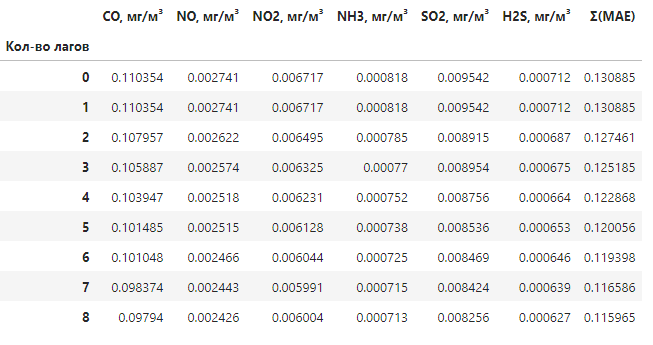

In [35]:
mae_df = create_df()
meteo_params = ['T внеш., °C', 'P атм., мм.рт.ст.', 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']

In [36]:
def make_df(df, num, target_num, lags=None):
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    '''

    coor = locations_list[num - 1]
    target_coor = locations_list[target_num - 1]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    if lags:
        for i in range(1, lags):
            df[f"T внеш_{i}"] = df['T внеш., °C'].shift(i)        # для нового столбца
            df[f"P атм._{i}"] = df['P атм., мм.рт.ст.'].shift(i)  # для нового столбца
            df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
            df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
            df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

In [37]:
points = [load_data(i, substances, meteo_params) for i in range(1, 7)]
df_melted_list = [melt_columns(df, substances, Mr, meteo_params) for df in points]

for lags in range(9):
    X_num_list = [concat_dfs(df_melted_list, j+1, lags) for j in range(len(df_melted_list))]
    
    for substance in substances:
        X, y = make_X_y()
        X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
        # Обучение
        cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
        cb.fit(X_train_scl, y_train)
        
        pred = cb.predict(X_test_scl)
        pred[pred < 0] = 0
        
        mae = mean_absolute_error(pred, y_test)
        mae_df.at[lags, substance] = mae
        
    # Сумма ошибок по всем веществам
    sum_mae = mae_df.loc[lags].sum()
    mae_df.at[lags, 'Σ(MAE)'] = sum_mae

In [38]:
# С добавлением температуры и давления
mae_df

,"CO, мг/м³","NO, мг/м³","NO2, мг/м³","NH3, мг/м³","SO2, мг/м³","H2S, мг/м³",Σ(MAE)
Кол-во лагов,,,,,,,
0,0.103102,0.002584,0.006077,0.000736,0.007434,0.00056,0.120492
1,0.103102,0.002584,0.006077,0.000736,0.007434,0.00056,0.120492
2,0.100085,0.002482,0.005946,0.000721,0.007237,0.000557,0.117029
3,0.096884,0.002405,0.00581,0.000709,0.00719,0.000545,0.113543
4,0.09469,0.002401,0.005785,0.000707,0.006905,0.000535,0.111025
5,0.09214,0.00236,0.00569,0.000685,0.006889,0.000532,0.108296
6,0.091513,0.002321,0.005604,0.000672,0.00674,0.000528,0.107378
7,0.08831,0.002325,0.005451,0.000654,0.006639,0.000527,0.103907
8,0.089136,0.002288,0.005533,0.000658,0.006453,0.000521,0.104589


С добавлением температуры и давления  
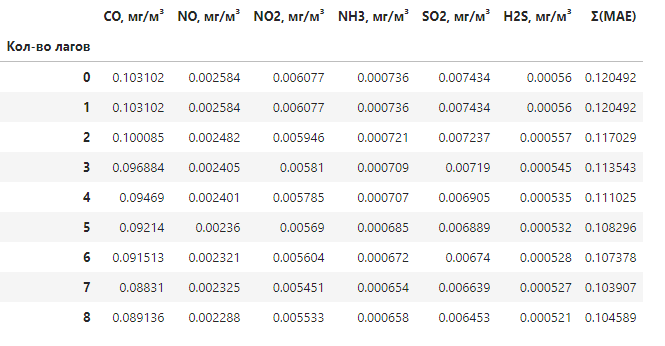

Итак, из метеопараметров выбираем параметры ветра, температуру, давление. Выберем временной сдвиг на 4 (lags=4) момента назад (т.е. на 2 часа).  
Обучим с этими параметрами модель и отберем наиболее важные признаки.

## Optuna

https://optuna.org/#code_examples  
https://habr.com/ru/articles/563494/  
https://www.kaggle.com/code/kingoffitpredict/time-optimization/notebook  
https://www.kaggle.com/code/tomokikmogura/catboost-hyperparameters-tuning-with-optuna  
https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/  

In [ ]:
import optuna

Метод k-ближайших соседей чувствителен к неинформативным признакам. Поэтому после избавления от лишних признаков стоит применить его еще раз.

In [ ]:
def objective(trial):
    
    # CatBoostRegressor
    catboost_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),    # =iterations
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
    }
    catboost = CatBoostRegressor(**catboost_params, random_state=0)

    # Support Vector Regression
    svr_params = {
        'C': trial.suggest_float('C', 0.1, 100),
        'epsilon': trial.suggest_float('epsilon', 0.01, 1),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
    }
    svr = SVR(**svr_params)

    # KNeighborsRegressor
    knn_params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
    }
    knn = KNeighborsRegressor(**knn_params)

    # Обучение
    catboost.fit(X_train_scl, y_train)
    svr.fit(X_train_scl, y_train)
    knn.fit(X_train_scl, y_train)

    # Прогнозы на тестовом наборе
    catboost_preds = catboost.predict(X_test_scl)
    svr_preds = svr.predict(X_test_scl)
    knn_preds = knn.predict(X_test_scl)

    # Вычисление ошибки
    catboost_mae = mean_absolute_error(y_test, catboost_preds)
    svr_mae = mean_absolute_error(y_test, svr_preds)
    knn_mae = mean_absolute_error(y_test, knn_preds)

    return catboost_mae + svr_mae + knn_mae

In [ ]:
for substance in substances:
    
    X_list_substance = copy.deepcopy(X_num_list)
    data_with_substance = []
    
    # Добавление целевой переменной
    for (num, X_num), point in zip(enumerate(X_list_substance), points):
        if substance in list(point):
            data_with_substance.append(X_num)
            data_with_substance[-1][f'target_{substance}'] = point[substance]
            
    X = pd.concat(data_with_substance, axis=0)
    X.dropna(inplace=True)
    X.drop_duplicates(inplace=True)
    X = pd.get_dummies(X, columns=['Направление ветра'])
    
    y = X.pop(f'target_{substance}')

    # Разбиваем и масштабируем
    X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)

    # Запуск оптимизации гиперпараметров
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)

    print('Best hyperparameters:', study.best_params)
    print(substance)
    print()